<a href="https://colab.research.google.com/github/rejishal/mywork/blob/main/DRL_Assignment_2(DQN_DDQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DRL 80:
### Group Members Name with Student ID:
    1. Susheel Malhotra  Id: 2023aa05711 Contribution: 100%
    4. Rejishal T K      Id: 2023aa05845 Contribution: 100%
    2. Atul Sharma       Id: 2023aa05154 Contribution: 100%
    2. Simit Das         Id: 2023aa05807 Contribution: 100%

# Steps for DQN and DDQN Implementation

## 1. Data Preprocessing
This part remains the same as described in the previous answer. You'll preprocess the dataset, handle missing values, and scale the features. The state space consists of 21 features, and the target variable is Appliances (energy consumption in Wh).

## 2. Action Space
In both DQN and DDQN, the action space is discrete:

- **Action 0**: Decrease temperature by 1°C.
- **Action 1**: Maintain current temperature.
- **Action 2**: Increase temperature by 1°C.

Each action will modify the 9 temperature features (T1-T9), and the state will transition to a new state as a result.

## 3. Deep Q-Network (DQN) Algorithm
The DQN uses a neural network to approximate the Q-value function, which is used to decide the best action at any given state.

### Algorithm Steps:

1. **Initialize Experience Replay**:
   - Store past experiences (state, action, reward, next state) to train the Q-network.

2. **Q-Network**:
   - A neural network that outputs Q-values for each action.

3. **Target Network**:
   - A copy of the Q-network to stabilize training. It is updated periodically with weights from the Q-network.

4. **Epsilon-Greedy Policy**:
   - The agent selects actions using an epsilon-greedy policy. It randomly selects actions with probability epsilon to explore and with probability \(1 - \epsilon\), it exploits by selecting the action with the highest Q-value.

5. **Loss and Training**:
   - Train the Q-network using the Bellman equation:
   \[
   Q(s,a) = r + \gamma \max_{a'} Q'(s',a')
   \]
   Where \(Q\) is the predicted Q-value, \(r\) is the reward, \(s'\) is the next state, and \(Q'\) is the target Q-value from the target network.

## 4. Double Deep Q-Network (DDQN)
The DDQN mitigates the overestimation bias in DQN by using two networks:

- **Q-Network**: Used to select the best action.
- **Target Network**: Used to evaluate the action selected by the Q-network.

In DDQN, the update rule becomes:
\[
Q(s,a) = r + \gamma Q'(s', \text{argmax}_a Q(s',a))
\]
Here, \(\text{argmax}_a Q(s', a)\) is the action chosen by the Q-network, and \(Q'\) is the target network that evaluates this action.


# Preprocessing

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
data = pd.read_csv(url)

# Preprocessing
features = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'RH_1', 'RH_2', 'RH_3',
            'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'Visibility', 'Tdewpoint',
            'Press_mm_hg', 'Windspeed']
target = 'Appliances'

# Handle missing values and scaling
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(scaled_data, data[target], test_size=0.2, shuffle=False)

<ipython-input-21-8b1ce4f0605c>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


# EnergyConsumption Environment Design

## Action Space
The action space consists of three discrete actions related to temperature control:

1. **Decrease Temperature (Action 0)**
   - This action decreases the current temperature setting by a defined amount (e.g., 1°C).

2. **Maintain Current Temperature (Action 1)**
   - This action keeps the current temperature setting unchanged.

3. **Increase Temperature (Action 2)**
   - This action increases the current temperature setting by a defined amount (e.g., 1°C).

## State Space
The state space is composed of 21 features that describe the environment's current state:

1. **Current Temperature**: The current indoor temperature.
2. **Target Temperature**: The desired indoor temperature set by the user.
3. **Humidity Level**: The current indoor humidity percentage.
4. **Outdoor Temperature**: The current outdoor temperature.
5. **Time of Day**: The current time (hour) of day.
6. **Day of the Week**: The current day (Monday to Sunday).
7. **Season**: The current season (Winter, Spring, Summer, Fall).
8. **Energy Consumption**: The current energy consumption level (in kWh).
9. **Thermostat Status**: Whether the HVAC system is currently active or idle.
10. **Window Status**: Whether windows are open or closed.
11. **Occupancy Level**: Number of occupants in the space.
12. **Previous Temperature Setting**: The last temperature setting before the current one.
13. **Heating System Efficiency**: Efficiency rating of the heating system (e.g., 90%).
14. **Cooling System Efficiency**: Efficiency rating of the cooling system (e.g., 85%).
15. **Air Quality Index**: A measure of indoor air quality.
16. **Thermostat Type**: Type of thermostat being used (smart, manual, etc.).
17. **Insulation Quality**: Quality of insulation in the building (poor, average, good).
18. **Energy Prices**: Current energy prices (if variable).
19. **Previous Energy Consumption**: Energy consumption in the previous time period.
20. **Forecasted Weather**: Forecast for the next few hours (temperature, humidity).
21. **User Preferences**: User-defined preferences for comfort (e.g., preferred temperature range).

## Environment Dynamics
- **Reward Function**: The reward can be defined based on energy savings, comfort levels (how close the indoor temperature is to the target), and possibly penalties for extreme temperature changes.
- **Transition Model**: The state transitions can depend on the selected action, current temperature, out

## Temperature Adjustment Functions
These are handled within the environment’s step function. Based on the action, the temperatures will either be decreased, maintained, or increased.door conditions, and system efficiencies.


In [22]:
import numpy as np
import random

class EnergyConsumptionEnv:
    def __init__(self, data):
        self.data = data
        self.max_steps = 250  #len(data) - 1  # Number of time steps (rows in dataset)
        self.current_step = 0
        self.state_size = data.shape[1]  # 21 features
        self.action_space = 3  # Three actions: Decrease, Maintain, Increase
        self.min_temp = -10
        self.max_temp = 30
        self.target_temp = 22

    def reset(self):
        self.current_step = 0
        return self.data[self.current_step]

    def step(self, action):
        state = self.data[self.current_step]

        if action == 0:
            state[:9] = np.maximum(state[:9] - 1, self.min_temp)
        elif action == 2:
            state[:9] = np.minimum(state[:9] + 1, self.max_temp)

        next_state = self.data[self.current_step + 1] if self.current_step < self.max_steps else state
        reward = self.calculate_reward(state)
        done = self.current_step >= self.max_steps
        self.current_step += 1
        return next_state, reward, done

    def calculate_reward(self, state):
        temp_deviation = np.sum(np.abs(state[:9] - self.target_temp))
        energy_consumption = state[-1]
        reward = -temp_deviation + (50 - energy_consumption)  # Example formula balancing comfort and energy
        return reward


# Parameters for Training the Agent

## Common Parameters for DQN and DDQN

In [59]:
# Parameters for the environment and training
num_episodes = 50
max_memory_capacity = 200
batch_size = 256
update_target_frequency = 10
discount_factor = 0.99
epsilon_initial = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
learning_rate = 0.001


# Replay Buffer Implementation
### A replay buffer is used to store experiences.

In [60]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def store(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def size(self):
        return len(self.memory)


# DQN Network Design
### Define the Q-network, which will predict the Q-values for each state-action pair.

In [61]:
import tensorflow as tf

def build_q_network(state_size, action_size, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(state_size,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(action_size, activation='linear')  # Q-values for each action
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model


# DQN Training

In [71]:
def train_dqn(env, q_network, target_network, buffer, episodes, epsilon, epsilon_min, epsilon_decay):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.state_size])
        total_reward = 0

        for step in range(env.max_steps):
            if np.random.rand() <= epsilon:
                action = random.randrange(env.action_space)
            else:
                q_values = q_network.predict(state)
                action = np.argmax(q_values[0])

            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, env.state_size])
            buffer.store((state, action, reward, next_state, done))

            if buffer.size() > batch_size:
                minibatch = buffer.sample(batch_size)
                for experience in minibatch:
                    s, a, r, s_next, d = experience
                    target = r
                    if not d:
                        target = r + discount_factor * np.amax(target_network.predict(s_next)[0])
                    target_f = q_network.predict(s)
                    target_f[0][a] = target
                    q_network.fit(s, target_f, epochs=1, verbose=0)

            state = next_state
            total_reward += reward

            if done:
                break

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if episode % update_target_frequency == 0:
            target_network.set_weights(q_network.get_weights())

        print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward}, Epsilon: {epsilon}")
        total_rewards.append(total_reward)
    return total_rewards


# DDQN Implementation

In [72]:
def train_ddqn(env, q_network, target_network, buffer, episodes, epsilon, epsilon_min, epsilon_decay):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.state_size])
        total_reward = 0

        for step in range(env.max_steps):
            if np.random.rand() <= epsilon:
                action = random.randrange(env.action_space)
            else:
                q_values = q_network.predict(state)
                action = np.argmax(q_values[0])

            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, env.state_size])
            buffer.store((state, action, reward, next_state, done))

            if buffer.size() > batch_size:
                minibatch = buffer.sample(batch_size)
                for experience in minibatch:
                    s, a, r, s_next, d = experience
                    target = r
                    if not d:
                        best_action = np.argmax(q_network.predict(s_next)[0])
                        target = r + discount_factor * target_network.predict(s_next)[0][best_action]
                    target_f = q_network.predict(s)
                    target_f[0][a] = target
                    q_network.fit(s, target_f, epochs=1, verbose=0)

            state = next_state
            total_reward += reward

            if done:
                break

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if episode % update_target_frequency == 0:
            target_network.set_weights(q_network.get_weights())

        print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward}, Epsilon: {epsilon}")
        total_rewards.append(total_reward)

    return total_rewards


In [73]:
# Initialize environment, replay buffer, and Q-networks
env = EnergyConsumptionEnv(X_train)
buffer = ReplayBuffer(max_memory_capacity)
q_network = build_q_network(env.state_size, env.action_space, learning_rate)
target_network = build_q_network(env.state_size, env.action_space, learning_rate)
target_network.set_weights(q_network.get_weights())
#dqn_rewards = train_dqn(env, q_network, target_network, buffer, num_episodes, epsilon_initial, epsilon_final, epsilon_decay)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
# Train the DQN agent
dqn_rewards = train_dqn(env, q_network, target_network, buffer, num_episodes, epsilon_initial, epsilon_final, epsilon_decay)
#print("Current DDQN Reward:" + dqn_rewards)


Episode 1/50, Reward: -42635.17246578866, Epsilon: 0.995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Episode 2/50, Reward: -42559.655691768465, Epsilon: 0.990025
Episode 3/50, Reward: -42454.07412764424, Epsilon: 0.985074875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 4/50, Reward: -42328.07412764424, Epsilon: 0.9801495006250001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Episode 5/50, Reward: -42202.07412764425, Epsilon: 0.9752487531218751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/

In [75]:
# Train the DQN agent
ddqn_rewards = train_ddqn(env, q_network, target_network, buffer, num_episodes, epsilon_initial, epsilon_final, epsilon_decay)


Episode 1/50, Reward: -37128.53672217197, Epsilon: 0.995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Episode 2/50, Reward: -37118.57859059709, Epsilon: 0.990025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 3/50, Reward: -37113.484962275135, Epsilon: 0.985074875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Episode 4/50, Reward: -36893.38186397125, Epsilon: 0.9801495006250001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 5/50, Reward: -36758.978647695476, Epsilon: 0.9752487531218751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

# Plotting Results


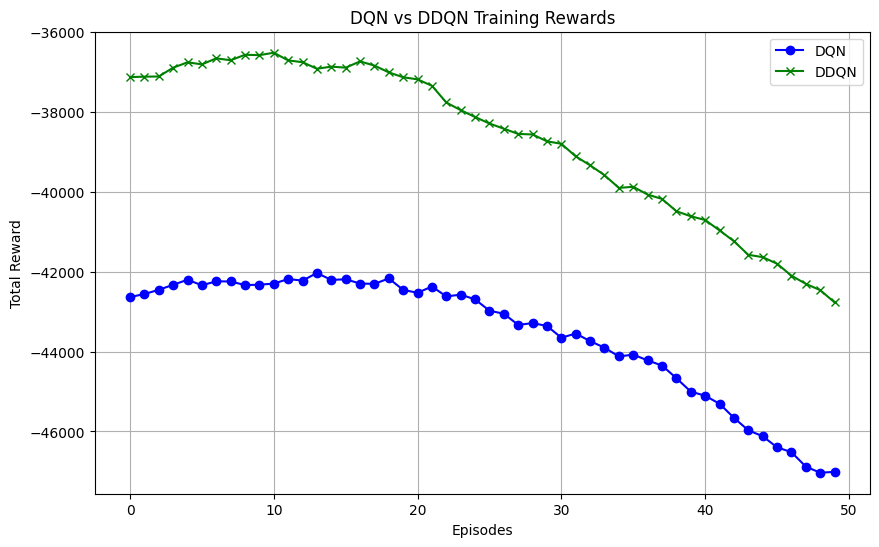

In [78]:
import matplotlib.pyplot as plt

# Example reward lists (Replace these with the actual rewards obtained from training)
#dqn_rewards = [10, 15, 20, 18, 25, 30, 32, 28, 35, 40]  # Rewards for DQN
#ddqn_rewards = [12, 18, 22, 20, 27, 33, 34, 30, 37, 42]  # Rewards for DDQN

#print(dqn_rewards)

# Plotting the rewards for DQN and DDQN
plt.figure(figsize=(10, 6))

plt.plot(dqn_rewards, label="DQN", color='b', marker='o')
plt.plot(ddqn_rewards, label="DDQN", color='g', marker='x')

plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN vs DDQN Training Rewards")
plt.legend()

plt.grid(True)
plt.show()
